# Data Science Capstone - The Best Neighborhood in New York to open a restaurant supply store

## Introduction


### Business Problem
- The City of New York is famous for its excellent cuisine. It's food culture includes an array of international cuisines influenced by the city's immigrant history. 
 - Due to this influence, many restaurants are operational in the city catering to a wide variety of audience. This also means that there is a huge demand for the supply of items needed to run these restaurants.
 - In this analysis, we will discuss the optimal place to start a restaurant supply chain shop which can cater to maximum restaurants.
 

### Target Audience
The target audience for this problem is any client who would like to find the optimal location for opening a restaurant supply store.

## Data Collection

### Data Requirements:
1. We will need a list of New York neighborhoods along with longitude and latitude information.
We start by collecting data about New York which orimarily comprises of its Neighborhoods, Boroughs and the corresponding Latitude and Longitude information. Below link contains the required information -
https://geo.nyu.edu/catalog/nyu-2451-34572


2. We will need a list of all Restaurant Venues from all neighborhoods in New York
We use FOURSQUARE API to download all venues which are related to food from all neighborhoods in New York. https://api.foursquare.com

 - Venues related to food can be filtered by passing the category identifier obtained from website - https://developer.foursquare.com/docs/resources/categories
 

3. Combine all of those into a working Data Set to cluster and geo spatial map of the results showing the best neighborhood to open a Restaurant Supply Store in New York

Combining all of these disparate data sets will clearly demonstrate the following:
 - which neighborhoods in New York have clusters of like Restaurants
 - which neighborhood should the client target to open their new store.

Let's start by importing the required libraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize


!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans

!pip install folium
import folium

     |████████████████████████████████| 94 kB 2.5 MB/s eta 0:00:011


First we need to obtain the data for New York which contains data such as Neighborhoods and Boroughs along with their respective Latitude and Longitude Information. As mentioned in the data requirements section, this data can be obtained using the URL https://geo.nyu.edu/catalog/nyu-2451-34572. Sometimes the geojson file might not download. Hence I have placed the file at the following location - https://cocl.us/new_york_dataset.

Now lets import the geojson file and construct our dataframe with required values.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


In [4]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


As we can see, the neighborhoods dataframe contains the relevant information we need to process and analyze data related to New York.

Next, we retrieve the coordinates of New York city using Geocoder.

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Next we plot the dataframe using coordinates to make sure that the data is in correct format.

In [6]:
import folium
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Since maps are not available in the note, attached is an image which shows the generated graph.

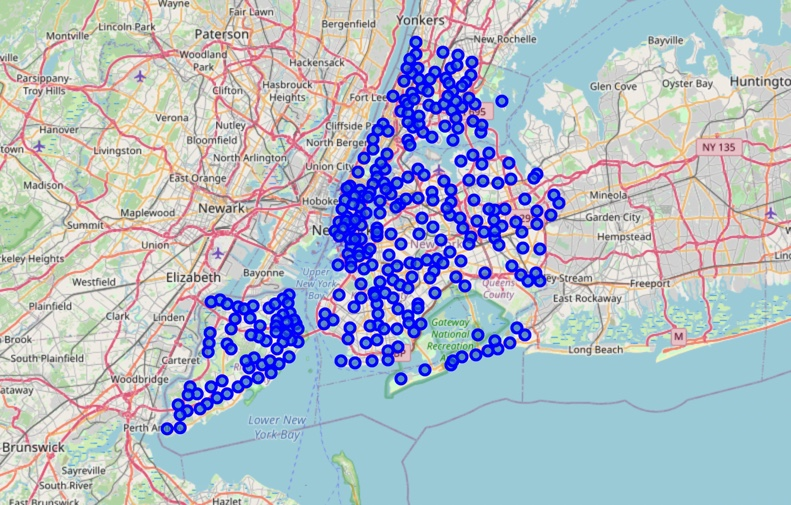

Below are the foursquare API credentials, but are hidden for security reasons

In [7]:
# @hidden_cell

#Foursquare credentials
CLIENT_ID = 'HKBVLXQIARURMUHI4TYR53P5TJYHEGRMUFY5ZUWCYBCSSDCL' # your Foursquare ID
CLIENT_SECRET = 'W5QFW43G31Q2ES2D1FHRWNUADHQET3INDNVIWFALRGNGHD41' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Below function retrieves the list of venues from Foursquare API using the dataframe we had constructed earlier

In [8]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

Next, we use the above function to retrieve the list of venues in New York which are related to food. This done by passing a variable called as "categoryId". This can be obtained from the Foursquare developer website as given below - https://developer.foursquare.com/docs/resources/categories.
The id for food is 4d4b7105d754a06374d81259.

In [9]:
#https://developer.foursquare.com/docs/resources/categories
#food = 4d4b7105d754a06374d81259
newyork_venues_food = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4d4b7105d754a06374d81259')
newyork_venues_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Margaritaville Restaurant and Lounge,40.898564,-73.837016,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Essa Deli,40.892181,-73.854427,Deli / Bodega
4,Wakefield,40.894705,-73.847201,Big Daddy's Caribbean Taste Restaurant,40.899767,-73.857135,Caribbean Restaurant


As we can see, the returned venues are all related to Food.

Next we will group the above data by Neighborhood

In [10]:
copy_of_venues = newyork_venues_food
copy_of_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,50,50,50,50,50,50
Annadale,28,28,28,28,28,28
Arden Heights,31,31,31,31,31,31
Arlington,36,36,36,36,36,36
Arrochar,45,45,45,45,45,45
Arverne,28,28,28,28,28,28
Astoria,50,50,50,50,50,50
Astoria Heights,48,48,48,48,48,48
Auburndale,50,50,50,50,50,50


### Analyze each Neighborhood

In [11]:
# one hot encoding
ny_onehot = pd.get_dummies(copy_of_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = copy_of_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bangladeshi Restaurant,Bar,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Convenience Store,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doner Restaurant,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health Food Store,Himalayan Restaurant,Hookah Bar,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Organic Grocery,Other Nightlife,Pakistani Restaurant,Park,Pastry Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pie Shop,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Pub,Puerto Rican Restaurant,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Next we calculate the mean of each venue type within a Neighborhood

In [12]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bangladeshi Restaurant,Bar,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Bookstore,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Convenience Store,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Doner Restaurant,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gas Station,Gastropub,German Restaurant,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym / Fitness Center,Halal Restaurant,Hawaiian Restaurant,Health Food Store,Himalayan Restaurant,Hookah Bar,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Organic Grocery,Other Nightlife,Pakistani Restaurant,Park,Pastry Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pie Shop,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Pub,Puerto Rican Restaurant,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint,Yemeni Restaurant
0,Allerton,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.060000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.060000,0.0,0.060000,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.02,0.0,0.020000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060000,0.0,0.0,0.0,0.0,0.0,0.080000,0.0,0.0,0.0,0.0,0.000000,0.0,0.060000,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.060000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.02,0.0,0.0,0.0,0.000000,0.0,0.0,

We use silhouette_score to calculate the optimal number of clusters which can be used to cluster the above data

In [15]:
from sklearn.metrics import silhouette_score


ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# Use silhouette score to find optimal number of clusters to segment the data
kclusters = np.arange(2,10)
results = {}
for size in kclusters:
    model = KMeans(n_clusters = size).fit(ny_grouped_clustering)
    predictions = model.predict(ny_grouped_clustering)
    results[size] = silhouette_score(ny_grouped_clustering, predictions)

print("silhouette_score results : ",results)
best_size = max(results, key=results.get)
best_size

silhouette_score results :  {2: 0.17743357998254314, 3: 0.14066439991387775, 4: 0.12914863106062802, 5: 0.1328577503914053, 6: 0.11736892508853244, 7: 0.12027984810897324, 8: 0.08326902182481445, 9: 0.07694941825109619}


2

From the above output we can see that dividing the data into 2 clusters provides maximum silhouette_score, hence we will be using 2 as our KMeans cluster size.

In [16]:
kclusters = best_size


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

Below is the function to calculate most common venue within a Neighborhood

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We are interested in top 10 venues in each Neighborhood

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Deli / Bodega,Pizza Place,Donut Shop,Food,Bakery,Mexican Restaurant,Caribbean Restaurant,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant
1,Annadale,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Restaurant,Bakery,Bagel Shop,Food,Deli / Bodega,Diner
2,Arden Heights,Pizza Place,Italian Restaurant,American Restaurant,Food,Sushi Restaurant,Mexican Restaurant,Chinese Restaurant,Restaurant,Deli / Bodega,Sandwich Place
3,Arlington,Deli / Bodega,Pizza Place,Ice Cream Shop,American Restaurant,Fast Food Restaurant,Spanish Restaurant,Coffee Shop,Peruvian Restaurant,Donut Shop,Polish Restaurant
4,Arrochar,Deli / Bodega,Pizza Place,Chinese Restaurant,Italian Restaurant,Food,Bagel Shop,Food Truck,Sandwich Place,Juice Bar,Restaurant


Let's add the Cluster Label's to the dataframe

In [19]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = neighborhoods
ny_merged = ny_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0,Caribbean Restaurant,Deli / Bodega,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Food,Asian Restaurant,Southern / Soul Food Restaurant,Steakhouse,Juice Bar
1,Bronx,Co-op City,40.874294,-73.829939,0,Bakery,Chinese Restaurant,Deli / Bodega,Fast Food Restaurant,Donut Shop,Caribbean Restaurant,Fried Chicken Joint,Mexican Restaurant,Seafood Restaurant,American Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,0,Pizza Place,Deli / Bodega,Caribbean Restaurant,Fast Food Restaurant,Bakery,Donut Shop,Chinese Restaurant,Burger Joint,Café,Asian Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,0,Pizza Place,Mexican Restaurant,Deli / Bodega,Fast Food Restaurant,Bagel Shop,Donut Shop,Sushi Restaurant,Bakery,Sandwich Place,Diner
4,Bronx,Riverdale,40.890834,-73.912585,0,Pizza Place,Diner,Bagel Shop,Deli / Bodega,Fast Food Restaurant,Café,Mexican Restaurant,Food Truck,Bakery,Sandwich Place


### Visualizing the clusters

Let's visualize the clusters within a map using folium.

In [20]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

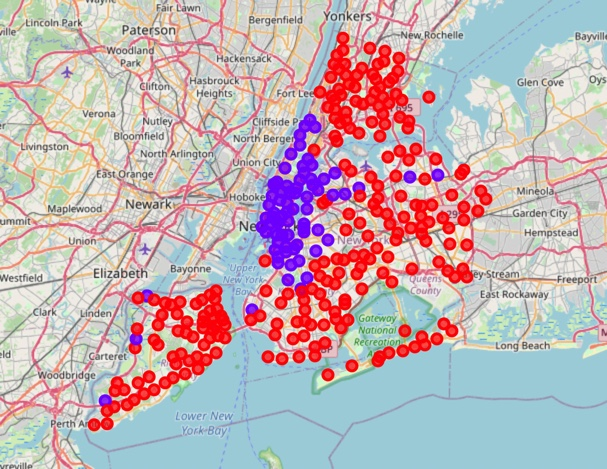

Since we have divided the data into 2 clusters, let's check which cluster has more number of elements by inspecting its shape.

In [21]:
ny_merged_0 = ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1, 2, 3] + list(range(5, ny_merged.shape[1]))]]
ny_merged_0.shape

(233, 13)

In [22]:
ny_merged_1 = ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1, 2, 3] + list(range(5, ny_merged.shape[1]))]]
ny_merged_1.shape

(73, 13)

__We observe that the cluster 0 has more elements. Hence we will be picking Cluster 0 for further processing.__

## Now we have the list of restaurants and other relevant details from the Cluster 0. For catering to these restaurants from an optimal location, we find the centroid of all the locations within this cluster. This means that this centroid will be able to cater to these restaurants with minimal transport costs and yet connect with outer lying points easily.

In [23]:
Cluster_0_coord = ny_merged_0[['Latitude', 'Longitude']]
Cluster_0_coord = list(Cluster_0_coord.values) 
lat = []
long = []



for l in Cluster_0_coord:
    lat.append(l[0])
    long.append(l[1])



Blatitude = sum(lat)/len(lat)
Blongitude = sum(long)/len(long)
print(Blatitude)
print(Blongitude)

40.69394045210022
-73.93700185136717


The above calculation has been obtained from the following link https://stackoverflow.com/questions/37885798/how-to-calculate-the-midpoint-of-several-geolocations-in-python

We now have the centrail point of all the Cluster 0 data items. Now we need to find where exactly these locations point to in the map of New York including the address. We use __OpenCageGeocode__ to reverse geocode the coordinates into an address.

In [24]:
# @hidden_cell

key = '0f491c7cd1254a4f8db24ca4d9b83a5f'

In [25]:
!pip install opencage
from opencage.geocoder import OpenCageGeocode
from pprint import pprint
geocoder = OpenCageGeocode(key)

results = geocoder.reverse_geocode(Blatitude, Blongitude)
pprint(results)

[{'annotations': {'DMS': {'lat': "40° 41' 38.85936'' N",
                          'lng': "73° 56' 13.17264'' W"},
                  'FIPS': {'state': '36'},
                  'MGRS': '18TWL8981305346',
                  'Maidenhead': 'FN30aq76no',
                  'Mercator': {'x': -8230628.347, 'y': 4939463.474},
                  'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=250316423#map=16/40.69413/-73.93699',
                          'note_url': 'https://www.openstreetmap.org/note/new#map=16/40.69413/-73.93699&layers=N',
                          'url': 'https://www.openstreetmap.org/?mlat=40.69413&mlon=-73.93699#map=16/40.69413/-73.93699'},
                  'UN_M49': {'regions': {'AMERICAS': '019',
                                         'NORTHERN_AMERICA': '021',
                                         'US': '840',
                                         'WORLD': '001'},
                             'statistical_groupings': ['MEDC']},
                  'call

Since this result does not give the Borough or the Neighborhood, we use manual search for Postcode 11206 to find the Neighborhood. Use the below link to view this data - https://www.unitedstateszipcodes.org/11206/

We print out the corresponding Borough and Neighborhood

In [26]:
popstring = neighborhoods[neighborhoods['Neighborhood'] == 'Williamsburg']

def str_join(*args):
    return ''.join(map(str, args))

popstring_new = str_join('The Best Neighbourhood to locate a Restaurant Supply Store is in: ', popstring['Neighborhood'].values,  ' in ' ,  popstring['Borough'].values)


print(popstring_new)

The Best Neighbourhood to locate a Restaurant Supply Store is in: ['Williamsburg'] in ['Brooklyn']


## Plotting the best neighbourhood to open a restaurant supply chain store in New York

In [27]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
folium.CircleMarker([Blatitude, Blongitude],
                    radius=50,
                    popup='New York',
                    color='red',
                    ).add_to(map_clusters)

# Interactive marker
map_clusters.add_child(folium.ClickForMarker(popup=popstring_new))
       
#map_clusters
map_clusters.save('map_clusters.html')
map_clusters

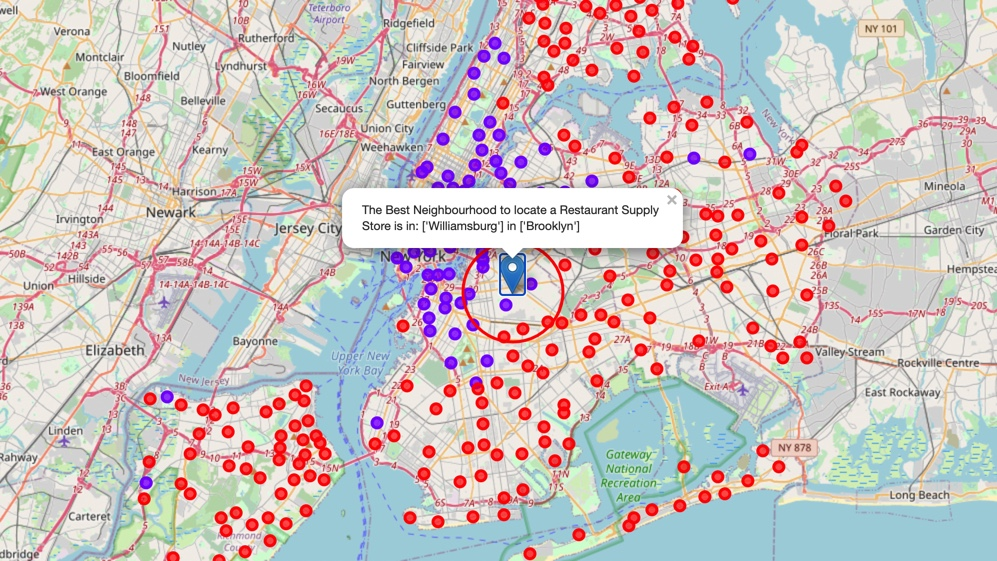

From the reverse lookup data, we can see that the exact address of the mid point is __Building 7, 93 Lewis Avenue, New York, NY 11206, United States of America__

## Discussion:

### Explaining the results

As we built our list of neighborhoods with Restaurant venues, we discovered most neighborhoods were similar and are evenly spread across New York. By starting his restaurant supply store in the general vicinity of the exact location shown above, my client will be able to service their customers more efficiently since its located mid-point between outer lying areas on either side and even within reach of the other cluster.

When we built our our K-Means dataset we used Silhouette analysis to tell us there was a lot of similarity between neighborhoods and the most common restaurants contained with in. Really there was only 2 types of cluster or neighborhoods in New York. The vast majority of those were in cluster 0.

## Conclusion:

I feel confident with the recommendation I have given my client as it is backed up with demonstrated data analysis. While nothing can ever be 100% certain they will certainly be better informed than they were prior to this comprehensive analysis.

Much more inference can be obtained with more work. A potential side business for my client might be assisting new restaurant owners where they might locate a new restaurant, who their competition is and who their clientele might be.